In [132]:
import numpy as np 
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
import matplotlib

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from gensim.models import word2vec
from sklearn.decomposition import PCA
import seaborn as sns

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn import svm

from sklearn.linear_model import LogisticRegression

# Data Processing and Cleaning

In [134]:
true_data = pd.read_csv('archive/True.csv')
fake_data = pd.read_csv('archive/Fake.csv')
# combine into one data set, with true = 1 and fake = 0
true_data['Category'] = '1'
fake_data['Category'] = '0'
df = pd.concat([true_data, fake_data], axis = "columns")
df = df.drop(df.index[21417:])

In [135]:
df = pd.concat([fake_data, true_data]).reset_index(drop = True)
df.drop(df.columns[[2, 3]], axis = 1, inplace = True)
df.head()

,title,text,Category
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0


In [136]:
stop_words = set(stopwords.words('english'))
st = SnowballStemmer('english')

def clean_data(df, col, clean_col):
    # shuffle data
    df = shuffle(df)
    
    # lowercase
    df[clean_col] = df[col].apply(lambda x: x.lower().strip())
    
    # punctuation
    df[clean_col] = df[clean_col].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))
    
    # stopwords
    df[clean_col] = df[clean_col].apply(lambda x: ' '.join(st.stem(text) for text in x.split() if text not in stop_words))
    
    return df

In [137]:
lemmatizer = WordNetLemmatizer()
# Simple Lemmatization
def simple_lemmatize(title):
    temp_list = []
    for word in nltk.word_tokenize(title):
        temp_list.append(lemmatizer.lemmatize(word))
    return ' '.join([str(elem) for elem in temp_list])

In [138]:
df = clean_data(df, "title", "Title Clean")
df.columns

Index(['title', 'text', 'Category', 'Title Clean'], dtype='object')

In [139]:
# nltk.download('punkt')
# nltk.download('omw-1.4')
#lemmatization
def process_lemma(unprocessed_list, total_items):
    output_list = []
    count = 0
    for item in unprocessed_list:
        if item != ' ':            
            #Simple
            output_list.append(simple_lemmatize((item)))
        else:
            output_list.append(' ')
        
        count += 1
        
        if count % 10000 == 0:
            print("{:.2%}".format(count / total_items))
        
    return output_list

df['Title_Lemma'] = process_lemma(df['Title Clean'], 44898)
df['Title_Lemma']

22.27%
44.55%
66.82%
89.09%


38912                  assad say syria war end deir al zor
38053    suspect graft indonesian parliament speaker gu...
41808    prankster cough fit mar theresa may speech act...
21129    man make viral video demonstr obama made cri g...
8102     autopsi report sf cop shot man time twice head...
                               ...                        
22240    trump execut order ethic commit ban lobbi exec...
8938     oregon militia terrorist die let fed arrest video
17037    christma octob american debt trillion dem want...
4517      trump blame charlott riot drug use without proof
44334    britain could still revers brexit former minis...
Name: Title_Lemma, Length: 44898, dtype: object

In [140]:
# need to convert data to Series for Decision Tree Classifier
X = df[['Title_Lemma']].squeeze()
y = df['Category'].squeeze()

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Confusion Matrix Function

In [52]:
def plot_confusion_matrix(y_test, pred_test, algo):
    confusion_training = confusion_matrix(y_test, pred_test)

    confusion_training = confusion_training.astype("float") / confusion_training.sum(axis=1)[:, np.newaxis]

    confusion_training = np.around(confusion_training, decimals=3)*100

    #create confusion matrix heat map
    f, axes = plt.subplots(figsize=(12,6))
    im = axes.imshow(confusion_training, interpolation="nearest", cmap = plt.cm.Blues)

    axes.figure.colorbar(im, ax=axes)
    axes.set(title=("Confusion Matrix: {}").format(algo), \
             xticks=np.arange(confusion_training.shape[1]), \
             yticks=np.arange(confusion_training.shape[0]), \
             xticklabels=range(1, 3), yticklabels=range(1, 3), \
             xlabel="Predicted", ylabel="Truth")

    axes.tick_params(axis='x', labelsize=14)
    axes.tick_params(axis='y', labelsize=14)
    axes.title.set_fontsize(20)
    axes.xaxis.set_ticklabels(['True', 'Fake'])
    axes.yaxis.set_ticklabels(['True', 'Fake'])

    #add clear annotations to the confusion matrix
    threshold = confusion_training.max()/1.5
    for i in range(confusion_training.shape[0]):
        for j in range(confusion_training.shape[1]):
            axes.text(j, i, f"{confusion_training[i, j]:.0f}%",
                    ha="center", va="center",
                    color="white" if confusion_training[i, j] > threshold else "black")

    f.tight_layout()
    plt.savefig(('{} Testing Confusion.png').format(algo), dpi = 300)
    plt.show()

# Decision Tree Classifier

In [10]:
# Vectorizing and applying TF-IDF for decision tree classifier
max_depth = 100

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = max_depth, 
                                           splitter='best', 
                                           random_state=0))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))


accuracy: 88.39%


In [11]:
#accuracy is around 89%. To improve, try to fix clean data
# using lemma reduced to 88

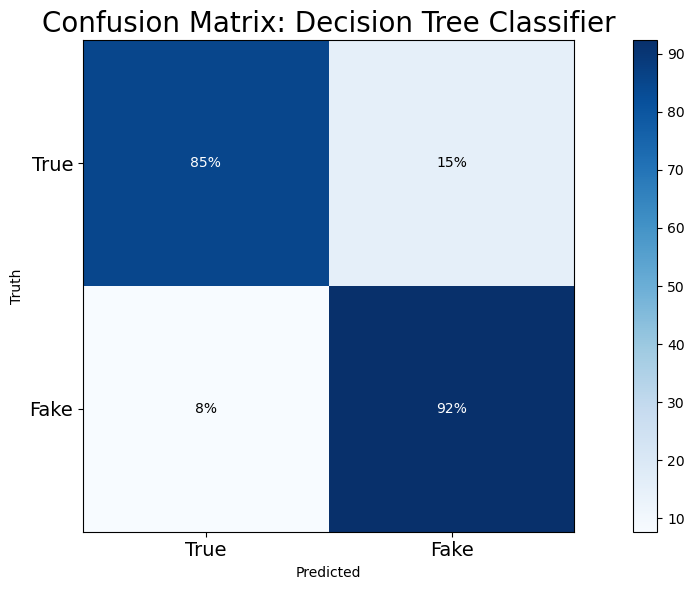

In [58]:
plot_confusion_matrix(y_test, prediction, "Decision Tree Classifier")

# Naive Bayes

In [12]:
# naive bayes algo
# X_train_float = X_train.to_numpy()
# when using to_numpy(), results increase by 1%
model2 = make_pipeline(TfidfVectorizer(), MultinomialNB())
# nb = GaussianNB()
clf = model2.fit(X_train, y_train)

pred_NB = model2.predict(X_test)

In [13]:
# Use score method to get accuracy of the model
print('--------------------------------------------------------')
score = model2.score(X_test, y_test)
print('Accuracy Score: ', score)
print('--------------------------------------------------------')

# Look at classification report to evaluate the model
print(classification_report(y_test, pred_NB))

print("accuracy: {}%".format(round(accuracy_score(y_test, pred_NB)*100,2)))

Classes:  ['0' '1']
--------------------------------------------------------
Accuracy Score:  0.9357461024498887
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      4731
           1       0.94      0.92      0.93      4249

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980

accuracy: 93.57%


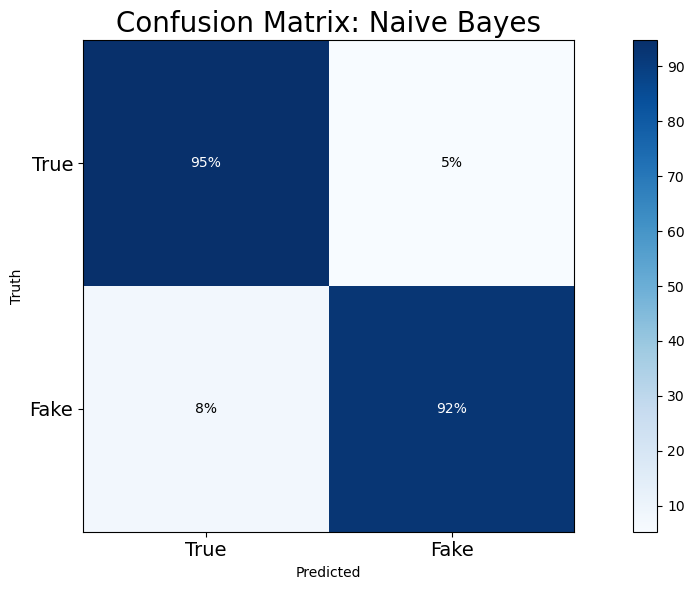

In [54]:
plot_confusion_matrix(y_test, pred_NB, "Naive Bayes")

# Random Forest Classifier

In [14]:
# random forest classifier
#this is pretty much bag of words
vectorizer = CountVectorizer(min_df=1)
X_rfc = vectorizer.fit_transform(X_train)

clf = RandomForestClassifier(n_estimators = 100, class_weight = None, criterion = "entropy").fit(X_rfc, y_train)

pred_rfc = clf.predict(vectorizer.transform(X_test).toarray())

In [24]:
print("accuracy: {}%".format(round(accuracy_score(y_test, pred_rfc)*100,2)))
print("F1 score: {}".format(round(f1_score(y_test, pred_rfc, average = "micro"), 2)))
print(classification_report(y_test, pred_rfc))
# did rfc function rearrange the order of X_test? 

accuracy: 94.34%
F1 score: 0.94
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      4731
           1       0.93      0.95      0.94      4249

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



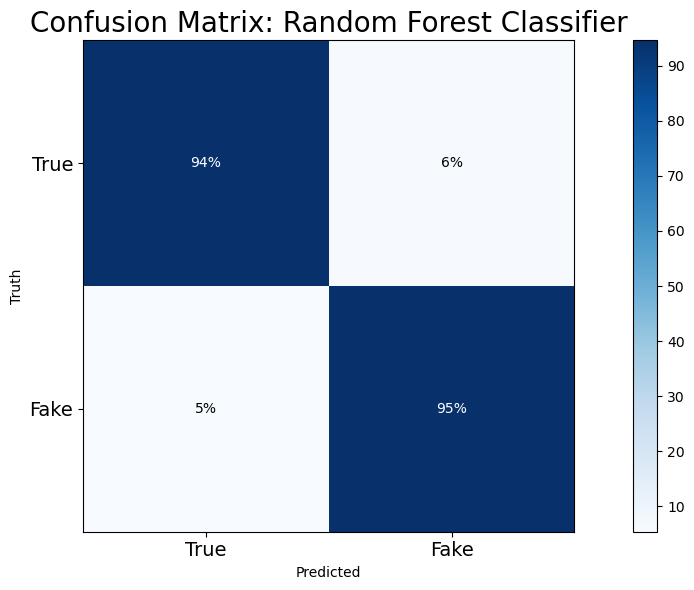

In [53]:
plot_confusion_matrix(y_test, pred_rfc, 'Random Forest Classifier')

# Logistic Regression

In [25]:
bow = CountVectorizer(tokenizer=lambda doc: doc)
bow_x = bow.fit_transform(df['Title Clean'])
words = bow.get_feature_names()

C:\Users\Gurpreet\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [26]:
X_tr, X_te, y_tr, y_te = train_test_split(bow_x, df['Category'], test_size=0.2, random_state=0)
X_tr

<35918x27 sparse matrix of type '<class 'numpy.int64'>'
	with 669392 stored elements in Compressed Sparse Row format>

In [69]:
model = LogisticRegression(C=1.0).fit(X_tr, y_tr)
pred_LR =model.predict(X_te)
score = model.score(X_te, y_te)
print(('Test Accuracy with bag of words Logistic Regression: {}%').format(round(score*100, 2)))

Test Accuracy with bag of words Logistic Regression: 76.97%


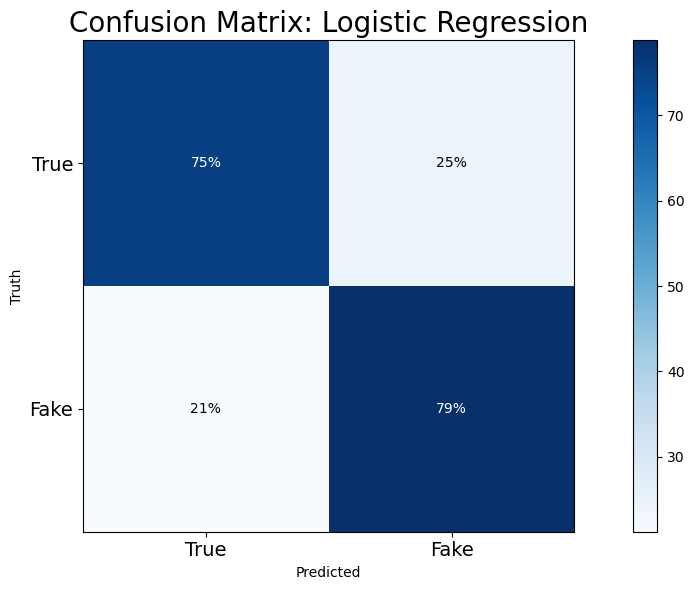

In [70]:
plot_confusion_matrix(y_te, pred_LR, "Logistic Regression")

# SVM

In [29]:
# SVM
Encoder = LabelEncoder()
Y_Train = Encoder.fit_transform(y_train)
Y_Test = Encoder.fit_transform(y_test)

In [31]:
#Also try naive bayes and rfc with tf-idf
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(df['Title Clean'])
Train_X_Tfidf = Tfidf_vect.transform(X_train)
Test_X_Tfidf = Tfidf_vect.transform(X_test)

In [34]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Y_Train)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ", round(accuracy_score(predictions_SVM, Y_Test)*100, 2))

SVM Accuracy Score ->  94.53


In [33]:
print(classification_report(Y_Test,predictions_SVM))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      4731
           1       0.93      0.95      0.94      4249

    accuracy                           0.95      8980
   macro avg       0.94      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980



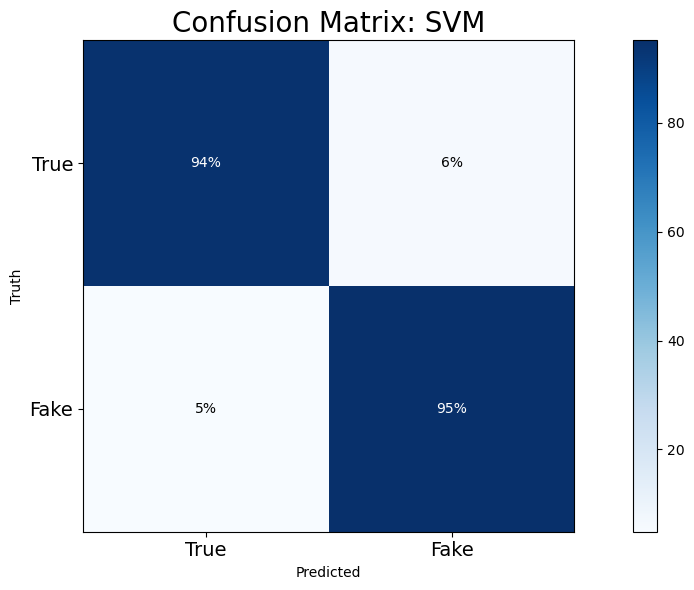

In [56]:
plot_confusion_matrix(Y_Test, predictions_SVM, "SVM")

# Neural Network

In [142]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Embedding
from keras.layers import Dropout, BatchNormalization
from keras import losses, optimizers
from keras.optimizers import SGD

In [143]:
# use Neural Network to classify
from keras.preprocessing.text import Tokenizer
# redo text cleaning slightly differently
df.drop(df.columns[[3, 4]], axis = 1, inplace = True)

In [66]:
# Count Vectorizer cleans text for us by converting characters to lowercase, removing punc
# remove stop words first
X_data = df['title'].apply(lambda x: ' '.join(st.stem(text) for text in x.split() if text not in stop_words))
print(X_data)
X_data = shuffle(X_data)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data)
seq = tokenizer.texts_to_sequences(X_data)

14658    iran announc reason for arrest us sailors…they...
40941              germani fdp expect coalit form christma
19544    awesome! american flag come back after 1,000 v...
34681                  grow feud: trump, cruz escal attack
23439    syria ceasefir deal: a cynic ploy washington c...
                               ...                        
12580    oh my! anoth giant fli land on hillari clinton...
28736    trump budget plan boost pentagon, trim state d...
42682     yemen hadi see militari solut crisis: arabiya tv
33569                          barron endors kasich presid
29301    some sept. 11 famili join critic trump immigr ...
Name: title, Length: 44898, dtype: object


In [113]:
# maximum amount of words in title is 10
max_len = 10
# this will require padding since not all lists are that length
X_data = pad_sequences(seq, padding='post', maxlen=max_len)
Y_data = df['Category']
tokenizer.fit_on_texts(Y_data)
seqy = tokenizer.texts_to_sequences(Y_data)
Y_data = pad_sequences(seqy, padding='post', maxlen = 1)
feature_size = 100
context_size = 20
min_word = 1

#X_data = model_df.iloc[:, :-1]
#Y_data = model_df.iloc[:, -1]


In [114]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X_data, Y_data, test_size = 0.2)

In [115]:
# must embedd the data before training. This will convert the padded sequences into word vecs
max_words = 25000
dim = 16
model = Sequential()
model.add(Embedding(max_words, dim, input_length = max_len))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
BatchNormalization()
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
BatchNormalization()
model.add(Dense(1, activation='sigmoid'))
#model.compile(loss='MSE', optimizer='Adam', metrics=['accuracy']) 
model.compile(loss='MSE',
              optimizer=optimizers.Adam(1e-6),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 16)            400000    
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 64)                10304     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 6

In [116]:
# now validate the samples
epochs = 15
hist = model.fit(X_Train, Y_Train, validation_data = (X_Test,Y_Test), epochs=epochs, batch_size=100, verbose = 2)

Epoch 1/15
360/360 - 1s - loss: 1.1939 - accuracy: 0.3696 - val_loss: 1.2021 - val_accuracy: 0.4049 - 1s/epoch - 3ms/step
Epoch 2/15
360/360 - 1s - loss: 1.1911 - accuracy: 0.3953 - val_loss: 1.1995 - val_accuracy: 0.4421 - 824ms/epoch - 2ms/step
Epoch 3/15
360/360 - 1s - loss: 1.1886 - accuracy: 0.4195 - val_loss: 1.1970 - val_accuracy: 0.4715 - 822ms/epoch - 2ms/step
Epoch 4/15
360/360 - 1s - loss: 1.1859 - accuracy: 0.4386 - val_loss: 1.1944 - val_accuracy: 0.4904 - 850ms/epoch - 2ms/step
Epoch 5/15
360/360 - 1s - loss: 1.1831 - accuracy: 0.4594 - val_loss: 1.1918 - val_accuracy: 0.5017 - 845ms/epoch - 2ms/step
Epoch 6/15
360/360 - 1s - loss: 1.1803 - accuracy: 0.4738 - val_loss: 1.1892 - val_accuracy: 0.5111 - 843ms/epoch - 2ms/step
Epoch 7/15
360/360 - 1s - loss: 1.1779 - accuracy: 0.4848 - val_loss: 1.1866 - val_accuracy: 0.5149 - 825ms/epoch - 2ms/step
Epoch 8/15
360/360 - 1s - loss: 1.1749 - accuracy: 0.4942 - val_loss: 1.1839 - val_accuracy: 0.5173 - 808ms/epoch - 2ms/step
Epo

In [117]:
from keras.backend import clear_session
clear_session()

In [118]:
'''
Some issues faced are overfitting, in which case we can try to find additional data, or tune the model better
Tuning done so far is batch normalization, reducing layers, Dropout, increasing batch size
'''

'\nSome issues faced are overfitting, in which case we can try to find additional data, or tune the model better\nTuning done so far is batch normalization, reducing layers, Dropout, increasing batch size\n'

# Prediction

In [121]:
# prediction
Fake_ex = "Trump plans to marry Kim-Jong-Un in North Korea"
True_ex = "How Trump's legacy became 'pure poison' for independents"

In [123]:
def remove_stop_words(text):
    text = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word.isalpha() and not word in stop_words]
    return ' '.join(text)

In [146]:
clean_Fake = remove_stop_words(Fake_ex)
seq = tokenizer.texts_to_sequences([clean_Fake])
padded_sequence = pad_sequences(seq, maxlen=max_len)
model.predict(padded_sequence)[0][0]
clean_True = remove_stop_words(True_ex)
seq = tokenizer.texts_to_sequences([clean_True])
padded_sequence = pad_sequences(seq, maxlen=max_len)
model.predict(padded_sequence)[0][0]

1/1 [==============================] - 0s 11ms/step


0.52041405

In [147]:
# Does not work as well as expected
# area of improvement is the NN